In [1]:
# 1. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchaudio librosa soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Imports
import os
import glob
import torch
import torchaudio
import torch.nn as nn
import torchaudio.transforms as T
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


In [11]:
import os
import glob
import torch
import torchaudio
from torch.utils.data import Dataset
import torchaudio.transforms as T

class UrduDeepfakeDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform or T.MelSpectrogram(sample_rate=16000, n_mels=80)

        for label_dir, label in [("Bonafide", 0), ("Tacotron", 1), ("VITS TTS", 1)]:
            folder = os.path.join(base_dir, label_dir)
            wav_files = glob.glob(os.path.join(folder, "**/*.wav"), recursive=True)
            for path in wav_files:
                self.data.append(path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        waveform, sr = torchaudio.load(path)
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=16000)
        spec = self.transform(waveform).squeeze(0)  # shape: [n_mels, time]

        # Pad or truncate to fixed length
        max_len = 800
        if spec.shape[1] < max_len:
            pad_size = max_len - spec.shape[1]
            spec = F.pad(spec, (0, pad_size))
        else:
            spec = spec[:, :max_len]

        return spec, label



In [12]:
# CNN Model
class SimpleAASIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, F, T)
        x = self.net(x)
        return self.classifier(x.view(x.size(0), -1))

In [13]:
# Dataset & DataLoader Setup
base_path = "/content/drive/MyDrive/deepfake_detection_dataset_urdu"
dataset = UrduDeepfakeDataset(base_path)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)

In [14]:

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleAASIST().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
patience = 4
trigger = 0

for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            correct += (out.argmax(1) == yb).sum().item()

    acc = correct / len(val_ds)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break


Epoch 1: Train Loss=37.7244, Val Loss=0.0101, Val Acc=1.0000
Epoch 2: Train Loss=1.1869, Val Loss=0.0004, Val Acc=1.0000
Epoch 3: Train Loss=0.4500, Val Loss=0.0003, Val Acc=1.0000
Epoch 4: Train Loss=0.2432, Val Loss=0.0002, Val Acc=1.0000
Epoch 5: Train Loss=0.1541, Val Loss=0.0000, Val Acc=1.0000
Epoch 6: Train Loss=0.1030, Val Loss=0.0001, Val Acc=1.0000
Epoch 7: Train Loss=0.0749, Val Loss=0.0000, Val Acc=1.0000
Epoch 8: Train Loss=0.0562, Val Loss=0.0000, Val Acc=1.0000
Epoch 9: Train Loss=0.0439, Val Loss=0.0000, Val Acc=1.0000
Epoch 10: Train Loss=0.0351, Val Loss=0.0000, Val Acc=1.0000
Epoch 11: Train Loss=0.0281, Val Loss=0.0000, Val Acc=1.0000
Epoch 12: Train Loss=0.0231, Val Loss=0.0000, Val Acc=1.0000
Epoch 13: Train Loss=0.0186, Val Loss=0.0000, Val Acc=1.0000
Epoch 14: Train Loss=0.0161, Val Loss=0.0000, Val Acc=1.0000
Epoch 15: Train Loss=0.0135, Val Loss=0.0000, Val Acc=1.0000
Epoch 16: Train Loss=0.0116, Val Loss=0.0000, Val Acc=1.0000
Epoch 17: Train Loss=0.0098, Val

In [15]:
# Evaluation Function
def evaluate_model(model, test_loader, name="Model"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n🔍 {name} Classification Report:\n{classification_report(y_true, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
    }

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: U


🔍 Deepfake CNN (MelSpec) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       682

    accuracy                           1.00       682
   macro avg       1.00      1.00      1.00       682
weighted avg       1.00      1.00      1.00       682

Confusion Matrix:
[[682]]
Accuracy : 1.0000
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000
AUC      : nan


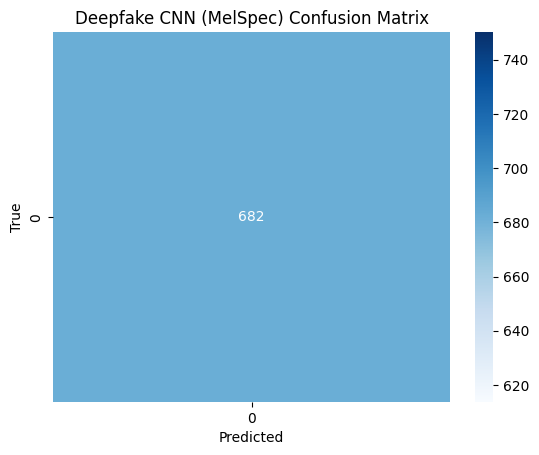

In [16]:
# Run Evaluation
metrics = evaluate_model(model, val_dl, name="Deepfake CNN (MelSpec)")
